In this notebook, we show some examples of how to use the benchmark.
You can also start trying the benchmark by just running `python scipts/ph_optimization.py`, 
which will run the benchmark with the default parameters.

First of all, we need to add paths of the benchmarks.

In [2]:
import sys
sys.path.append("..")
sys.path.append("../scripts")

## Table of Contents
1. [How to specify the data](##How-to-specify-the-data)

## How to specify the data

First, let us generate the point cloud to be optimized.
For convenience in later chapters, here, we define a function to generate the point cloud.

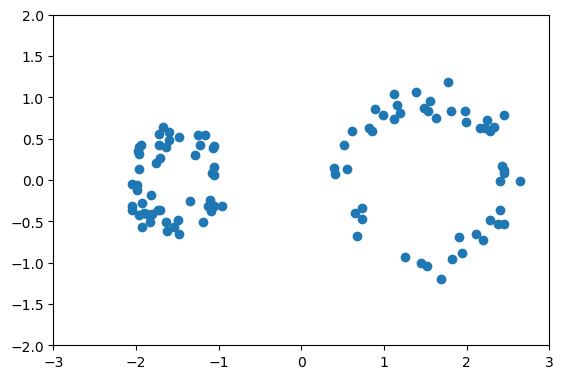

In [13]:
import numpy as np
import matplotlib.pyplot as plt


def large_hole_and_small_hole(num_pts: int) -> np.ndarray:
    small_num_pts, large_num_pts = num_pts//2, num_pts - num_pts//2
    X_list = []
    for k in range(1000):
        theta = np.random.rand(small_num_pts) * 2 * np.pi
        small = np.array([-1.5 + 0.5 * np.cos(theta), 0.5 * np.sin(theta)]).T
        theta = np.random.rand(large_num_pts) * 2 * np.pi
        large = np.array([+1.5 + 1.0 * np.cos(theta), 1.0 * np.sin(theta)]).T
        X = np.concatenate([small, large], axis=0)
        X_list.append(X)
    data = np.stack(X_list, axis=0) + np.random.randn(1000, num_pts, 2) * 0.1
    return data

X = large_hole_and_small_hole(100)
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_xlim(-3, 3); ax.set_ylim(-2, 2); ax.set_aspect('equal')
ax.scatter(X[0, :, 0], X[0, :, 1])
ax = fig.add_subplot(1, 2, 2)

plt.show()

## How to specify the persistent-based loss

Next, we describe the way to design the persistent-based loss.
When implementing the class that represents the loss, we need to be careful about the following points:
- The class should inherit the `PersistenceBasedLoss` class in `scripts/persistence_based_loss.py`.
- We have to implement the `__call__` method, which takes a point cloud and `RipsPH` object as input and returns the loss value.
Moreover, the class need to have `get_rph` decorator.
- We have to implement the `get_direction` method, which 

`RipsPH` is the class define in `scripts/lib/ph_computation_libirary.py`.
The object of `RipsPH` class has the information of the persistent homology of the point cloud.
Basically, the following two methods can be used to implement the loss function:
- `get_barcode`: obtain barcode with the format of list, np.ndarray or torch.Tensor.
- `get_differentiable_barcode`: obtain barcode with the format of differentiable torch.Tensor.
- `get_bar_object_list`: obtain barcode as a list of `Bar` objects. Please refer to `scripts/lib/ph_compute_library.py` for the definition of `Bar` class.

Now, we define our own loss function.
We use wasserstein distance as the loss function here.

In [ ]:
from scripts.persistence_based_loss import PersistenceBasedLoss, get_rph
from scripts.lib.ph_computation_library import Bar, RipsPH
from gudhi.wasserstein import wasserstein_distance
import torch
from typing import Optional

class WassersteinLoss(PersistenceBasedLoss):
    """
    Loss to minimize the Wasserstein distance between the persistent diagram of the input and a desirable persistent diagram.

    Parameters:
        - dim_list(list[int]): list of dimensions of the persistent homology.
        - desirable_pd(list[torch.Tensor]): the desirable persistent diagram. shape=(#bars, 2)
    """
    def __init__(self, dim_list: list[int], desirable_pd: list[torch.Tensor], order=2):
        super().__init__(dim_list)
        self.desirable_pd = desirable_pd
        self.order = order

    @get_rph
    def __call__(self, X: torch.Tensor, rph=Optional[RipsPH]) -> torch.Tensor:
        loss = 0
        for dim in self.dim_list:
            barcode: torch.Tensor = rph.get_differentiable_barcode(dim)
            loss += wasserstein_distance(barcode, self.desirable_pd[dim], order=self.order, enable_autodiff=True)
        return loss
    
    @get_rph
    def get_direction(self, X, rph=Optional[RipsPH]) -> list[tuple[int, list[Bar], torch.Tensor]]:
        ret = []
        for dim in self.dim_list:
            bars_to_move, direction = [], []
            bar_list = rph.get_bar_object_list(dim)
            barcode = torch.tensor([[bar.birth, bar.death] for bar in bar_list])
            _, matching = wasserstein_distance(barcode, self.desirable_pd[dim], order=self.order, matching=True)
            for i, j in matching:
                if i == -1:
                    continue
                elif j == -1:
                    bars_to_move.append(bar_list[i])
                    diff = barcode[i, 1] - barcode[i, 0]
                    direction.append(diff * torch.tensor([0.5, -0.5]))
                else:
                    bars_to_move.append(bar_list[i])
                    direction.append(self.desirable_pd[dim][j] - barcode[i])
            ret.append((dim, bars_to_move, torch.stack(direction, dim=0)))
        return ret

## How to use `scripts/ph_optimization.py`

The most basic use of this file is to call the function `ph_opt_main` with specifying the following parameters in OptConfig.
- `exp_name`: The name of the experiment. This will be used to the filename when saving the results.
- `method`: The method you use for the optimization.
- `lr`: The learning rate of the optimization.
- `num_epoch`: The number of epochs in the optimization.

In [ ]:
from scripts.ph_optimization import ph_opt_main, OptConfig
print(sys.argv)
# The following is almost same as `scripts/ph_optimization.py`
method_list = ["gd", "continuation", "bigstep"]
for method in method_list:
    config = OptConfig(exp_name=f"{method}", method=method, lr=0.1, num_epoch=100)
    ph_opt_main(config)

## Continuation as a method to track the point cloud along the path of PD